In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import json
import os 
import tensorflow as tf
import sklearn
import seaborn as sbs
import sklearn.naive_bayes 
import sklearn.model_selection
import sklearn.metrics


json_1 = './news_dataset/Sarcasm_Headlines_Dataset.json'
json_2 = './news_dataset/Sarcasm_Headlines_Dataset_v2.json'


def load_json(jfile):
    data = []
    with open(jfile) as f:
        for line in f.readlines():
            j = json.loads(line)
            url, headline, sarcastic = j['article_link'], j['headline'], j['is_sarcastic']
            data.append([url, headline, sarcastic])
    return pd.DataFrame(data, columns=['article_link', 'headline', 'is_sarcastic'])

print("✅✅✅ SESSION DONE")

df = load_json(json_1)
df2 = load_json(json_2)
df2.head()

✅✅✅ SESSION DONE


,article_link,headline,is_sarcastic
0,https://www.theonion.com/thirtysomething-scien...,thirtysomething scientists unveil doomsday clo...,1
1,https://www.huffingtonpost.com/entry/donna-edw...,dem rep. totally nails why congress is falling...,0
2,https://www.huffingtonpost.com/entry/eat-your-...,eat your veggies: 9 deliciously different recipes,0
3,https://local.theonion.com/inclement-weather-p...,inclement weather prevents liar from getting t...,1
4,https://www.theonion.com/mother-comes-pretty-c...,mother comes pretty close to using word 'strea...,1


In [4]:
# Now check the distribution (ratio) of our target is_sarcastic

df.is_sarcastic.value_counts(normalize=True), df.is_sarcastic.value_counts()

(0    0.561047
 1    0.438953
 Name: is_sarcastic, dtype: float64,
 0    14985
 1    11724
 Name: is_sarcastic, dtype: int64)

C:\Users\Furqan Ali\AppData\Local\Temp\ipykernel_9796\2040605187.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sbs.distplot(df.headline.str.len())


<AxesSubplot:xlabel='headline', ylabel='Density'>

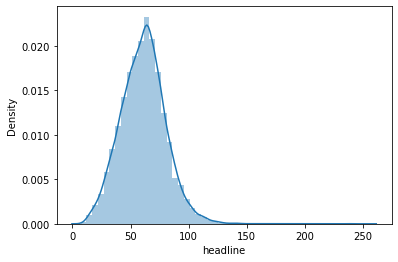

In [5]:
# A birdview of headline length. Seems the majority has a length of 70, that's about 5 to 15 words, which makes sence.
sbs.distplot(df.headline.str.len())

C:\Users\Furqan Ali\AppData\Local\Temp\ipykernel_9796\988797702.py:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sbs.distplot([len(l) for l in train_inputs])


<AxesSubplot:ylabel='Density'>

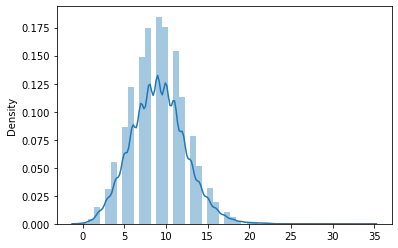

In [6]:
# Building Base Model: Naive Bayes
# First step, we should tokenize texts into vectors.

vocab_size = 10000 # max_features 
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=vocab_size)
tokenizer.fit_on_texts(df.headline)
train_inputs = tokenizer.texts_to_sequences(df.headline)
sbs.distplot([len(l) for l in train_inputs])

In [7]:
train_inputs = tf.keras.preprocessing.sequence.pad_sequences(train_inputs, padding='post', maxlen=20)
train_labels = df['is_sarcastic']

# Split data into train /validation 
X_train, X_val, y_train, y_val = sklearn.model_selection.train_test_split(train_inputs, train_labels, test_size=0.2, random_state=0)
train_inputs[0]

array([ 307,  678, 3336, 2297,   47,  381, 2575,    5, 2576, 8433,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0])

In [8]:
nb = sklearn.naive_bayes.MultinomialNB()
nb.fit(X_train, y_train)

MultinomialNB()

In [9]:
# Validate how the model performs.

# Turs out that the accuracy_score is only 0.58, which is merely a little better than random guess.
# But at least wew know what to expect now. 
# We're going to try more powerful models, e.g., CNN, to see whether we can reach a accuracy_score = 0.7 or higher

y_preds = nb.predict(X_val)
print(f"Accuracy score", sklearn.metrics.accuracy_score(y_val, y_preds))
print(f"Classification report\n", sklearn.metrics.classification_report(y_val, y_preds))

Accuracy score 0.5718831898165481
Classification report
               precision    recall  f1-score   support

           0       0.60      0.69      0.64      3007
           1       0.51      0.42      0.46      2335

    accuracy                           0.57      5342
   macro avg       0.56      0.55      0.55      5342
weighted avg       0.56      0.57      0.56      5342



In [10]:
# Another model: Keras LSTM

max_len = 20
text_input = tf.keras.Input(shape=(max_len, ))
embed_text = tf.keras.layers.Embedding(vocab_size, 128)(text_input)

net = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True))(embed_text)
net = tf.keras.layers.GlobalMaxPool1D()(net)
net = tf.keras.layers.Dense(64, activation='relu')(net)
net = tf.keras.layers.Dropout(0.4)(net)
net = tf.keras.layers.Dense(32, activation='relu')(net)
net = tf.keras.layers.Dropout(0.4)(net)

output = tf.keras.layers.Dense(1, activation='sigmoid')(net)
model = tf.keras.models.Model(text_input, output)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 20)]              0         
                                                                 
 embedding (Embedding)       (None, 20, 128)           1280000   
                                                                 
 bidirectional (Bidirectiona  (None, 20, 64)           41216     
 l)                                                              
                                                                 
 global_max_pooling1d (Globa  (None, 64)               0         
 lMaxPooling1D)                                                  
                                                                 
 dense (Dense)               (None, 64)                4160      
                                                                 
 dropout (Dropout)           (None, 64)                0     

In [11]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

mc = tf.keras.callbacks.ModelCheckpoint('model_best.hdf5', monitor='val_accuracy', 
                                        verbose=1, save_best_only=True, mode='max')
es = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy", mode="max", patience=5)
    
history = model.fit(X_train, y_train,
                    epochs=30, batch_size=256, callbacks=[mc, es], 
                    validation_split=0.1, verbose=1)

Epoch 1/30
72/76 [===========================>..] - ETA: 0s - loss: 0.5842 - accuracy: 0.6661
Epoch 1: val_accuracy improved from -inf to 0.84324, saving model to model_best.hdf5
76/76 [==============================] - 5s 23ms/step - loss: 0.5766 - accuracy: 0.6729 - val_loss: 0.3572 - val_accuracy: 0.8432
Epoch 2/30
71/76 [===========================>..] - ETA: 0s - loss: 0.2867 - accuracy: 0.8927
Epoch 2: val_accuracy improved from 0.84324 to 0.85821, saving model to model_best.hdf5
76/76 [==============================] - 1s 13ms/step - loss: 0.2865 - accuracy: 0.8920 - val_loss: 0.3255 - val_accuracy: 0.8582
Epoch 3/30
74/76 [============================>.] - ETA: 0s - loss: 0.1837 - accuracy: 0.9373
Epoch 3: val_accuracy improved from 0.85821 to 0.86008, saving model to model_best.hdf5
76/76 [==============================] - 1s 12ms/step - loss: 0.1836 - accuracy: 0.9371 - val_loss: 0.3614 - val_accuracy: 0.8601
Epoch 4/30
76/76 [==============================] - ETA: 0s - loss:

In [12]:
model = tf.keras.models.load_model('model_best.hdf5')
y_preds = model.predict(X_val, batch_size=1024).round().astype(int)
print("Test accracy score", sklearn.metrics.accuracy_score(y_val, y_preds))

6/6 [==============================] - 1s 4ms/step
Test accracy score 0.8558592287532759


In [13]:
# WordVector Embedding + LSTM

# We now use pretrained wordvector 
# https://code.google.com/archive/p/word2vec/ of Google News (after all, we're dealing with article headlines).

In [14]:
%%time
import gensim.downloader as api

def embed_word_vector(word_index, pretrained='word2vec-google-news-300'):
    embed_size = 300 # Google news vector is 300-dimensional
    vector = api.load(pretrained)
    zeros = [0] * embed_size
    matrix = np.zeros((vocab_size, embed_size)) 
    
    for word, i in word_index.items():
        if i >= vocab_size or word not in vector: continue 
        matrix[i] = vector[word]
    
    print("Embed word vector completed.")
    return matrix

CPU times: total: 15.6 ms
Wall time: 56 ms


In [15]:
# Update embedding layer weights of our model

pretrained = 'glove-wiki-gigaword-300'
matrix = embed_word_vector(tokenizer.word_index, pretrained=pretrained)

Embed word vector completed.


In [16]:
max_len = 20
text_input = tf.keras.Input(shape=(max_len, ))
embed_text = tf.keras.layers.Embedding(vocab_size, 300, weights=[matrix], trainable=False)(text_input)

net = tf.keras.layers.Bidirectional(tf.keras.layers.GRU(128, return_sequences=True))(embed_text)
net = tf.keras.layers.GlobalMaxPool1D()(net)
net = tf.keras.layers.Dense(64, activation='relu')(net)
net = tf.keras.layers.Dropout(0.4)(net)
net = tf.keras.layers.Dense(32, activation='relu')(net)
net = tf.keras.layers.Dropout(0.4)(net)

output = tf.keras.layers.Dense(1, activation='sigmoid')(net)
model = tf.keras.models.Model(text_input, output)
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 20)]              0         
                                                                 
 embedding_1 (Embedding)     (None, 20, 300)           3000000   
                                                                 
 bidirectional_1 (Bidirectio  (None, 20, 256)          330240    
 nal)                                                            
                                                                 
 global_max_pooling1d_1 (Glo  (None, 256)              0         
 balMaxPooling1D)                                                
                                                                 
 dense_3 (Dense)             (None, 64)                16448     
                                                                 
 dropout_2 (Dropout)         (None, 64)                0   

In [17]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

mc = tf.keras.callbacks.ModelCheckpoint('model_best_embed.hdf5', monitor='val_accuracy', 
                                        verbose=1, save_best_only=True, mode='max')
es = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy", mode="max", patience=5)
    
history = model.fit(X_train, y_train,
                    epochs=30, batch_size=256, callbacks=[mc, es], 
                    validation_split=0.1, verbose=1)

Epoch 1/30
76/76 [==============================] - ETA: 0s - loss: 0.5844 - accuracy: 0.6848
Epoch 1: val_accuracy improved from -inf to 0.79925, saving model to model_best_embed.hdf5
76/76 [==============================] - 4s 23ms/step - loss: 0.5844 - accuracy: 0.6848 - val_loss: 0.4361 - val_accuracy: 0.7993
Epoch 2/30
76/76 [==============================] - ETA: 0s - loss: 0.4113 - accuracy: 0.8221
Epoch 2: val_accuracy improved from 0.79925 to 0.83715, saving model to model_best_embed.hdf5
76/76 [==============================] - 1s 13ms/step - loss: 0.4113 - accuracy: 0.8221 - val_loss: 0.3585 - val_accuracy: 0.8372
Epoch 3/30
73/76 [===========================>..] - ETA: 0s - loss: 0.3282 - accuracy: 0.8675
Epoch 3: val_accuracy improved from 0.83715 to 0.85962, saving model to model_best_embed.hdf5
76/76 [==============================] - 1s 13ms/step - loss: 0.3282 - accuracy: 0.8673 - val_loss: 0.3195 - val_accuracy: 0.8596
Epoch 4/30
75/76 [============================>.]

In [18]:
# From the training history, we can see performance of this model is pretty similiar to our previous one. Thus, we know 
# pretrained NLP models are not going help us much. 

In [19]:
model = tf.keras.models.load_model('model_best_embed.hdf5')
y_preds = model.predict(X_val, batch_size=1024).round().astype(int)
print("Test accracy score", sklearn.metrics.accuracy_score(y_val, y_preds))

6/6 [==============================] - 1s 9ms/step
Test accracy score 0.8637214526394609


In [20]:
# BERT, NLP text classification killer

# import wget


# url = 'https://github.com/google-research/bert/blob/master/tokenization.py'
# filename = wget.download(url)
# print(filename)

In [21]:
import tensorflow_hub as hub 
import tokenization

module_url = 'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/2'
bert_layer = hub.KerasLayer(module_url, trainable=True)

In [22]:
vocab_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
do_lower_case = bert_layer.resolved_object.do_lower_case.numpy()
tokenizer = tokenization.FullTokenizer(vocab_file, do_lower_case)

In [23]:
def bert_encode(texts, tokenizer, max_len=512):
    all_tokens = []
    all_masks = []
    all_segments = []
    
    for text in texts:
        text = tokenizer.tokenize(text)
            
        text = text[:max_len-2]
        input_sequence = ["[CLS]"] + text + ["[SEP]"]
        pad_len = max_len - len(input_sequence)
        
        tokens = tokenizer.convert_tokens_to_ids(input_sequence) + [0] * pad_len
        pad_masks = [1] * len(input_sequence) + [0] * pad_len
        segment_ids = [0] * max_len
        
        all_tokens.append(tokens)
        all_masks.append(pad_masks)
        all_segments.append(segment_ids)
    
    return np.array(all_tokens), np.array(all_masks), np.array(all_segments)

def build_model(bert_layer, max_len=512):
    input_word_ids = tf.keras.Input(shape=(max_len,), dtype=tf.int32, name="input_word_ids")
    input_mask = tf.keras.Input(shape=(max_len,), dtype=tf.int32, name="input_mask")
    segment_ids = tf.keras.Input(shape=(max_len,), dtype=tf.int32, name="segment_ids")

    pooled_output, sequence_output = bert_layer([input_word_ids, input_mask, segment_ids])
    clf_output = sequence_output[:, 0, :]
    net = tf.keras.layers.Dense(64, activation='relu')(clf_output)
    net = tf.keras.layers.Dropout(0.2)(net)
    net = tf.keras.layers.Dense(32, activation='relu')(net)
    net = tf.keras.layers.Dropout(0.2)(net)
    out = tf.keras.layers.Dense(1, activation='sigmoid')(net)
    
    model = tf.keras.models.Model(inputs=[input_word_ids, input_mask, segment_ids], outputs=out)
    model.compile(tf.keras.optimizers.Adam(lr=1e-5), loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

In [24]:
# Remember in previous sections, we have explored on the headline length. Most of them has a length between 50 to 150,
# and the majority has a length of 70. We set the length to 120.

In [25]:
max_len = 100
X_train, X_val, y_train, y_val = sklearn.model_selection.train_test_split(df.headline, df['is_sarcastic'], 
                                                                          test_size=0.1, random_state=0)
X_train = bert_encode(X_train, tokenizer, max_len=max_len)
X_val = bert_encode(X_val, tokenizer, max_len=max_len)

In [26]:
# Let's build the model and train on it.

model = build_model(bert_layer, max_len=max_len)
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_word_ids (InputLayer)    [(None, 100)]        0           []                               
                                                                                                  
 input_mask (InputLayer)        [(None, 100)]        0           []                               
                                                                                                  
 segment_ids (InputLayer)       [(None, 100)]        0           []                               
                                                                                                  
 keras_layer_1 (KerasLayer)     [(None, 768),        109482241   ['input_word_ids[0][0]',         
                                 (None, 100, 768)]                'input_mask[0][0]',       

c:\users\furqan ali\desktop\python\env\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [27]:
%%time
checkpoint = tf.keras.callbacks.ModelCheckpoint('model.h5', monitor='val_accuracy', save_best_only=True, verbose=1)
earlystopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3, verbose=1)

train_history = model.fit(
    X_train, y_train, 
    validation_split=0.1,
    epochs=3,
    callbacks=[checkpoint, earlystopping],
    batch_size=16,
    verbose=1
)

Epoch 1/3


ResourceExhaustedError: Graph execution error:

OOM when allocating tensor with shape[1600,768] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node transformer/layer_2/self_attention/query/einsum/Einsum}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_train_function_81318]

In [ ]:
%%time
model.load_weights('bert_modelV1.h5')
y_preds = model.predict(X_val).round().astype(int)
print("Validation accuracy: ", sklearn.metrics.accuracy_score(y_val, y_preds))